In [1]:
from fastai.text import *
import html
import pandas as pd

from spacy.lang.en import English
from spacy.symbols import ORTH

/root/py36venv/lib64/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load INSPIRE data

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('inspire_data_with_reference_fractions_and_num_references_and_fake_data/')
PATH.mkdir(exist_ok=True)

In [3]:
CLAS_PATH = PATH / 'inspire_clas'
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH = PATH / 'inspire_lm'
LM_PATH.mkdir(exist_ok=True)

In [4]:
df_trn = pd.read_pickle('inspire_data_with_reference_fractions_and_num_references/inspire_data_train.df')
df_val = pd.read_pickle('inspire_data_with_reference_fractions_and_num_references/inspire_data_test.df')

## Prepare data for the Language Model

In [6]:
# Split the data into training (80 %) and validation (20 % splits)
trn_texts = np.array(df_trn['text'])
val_texts = np.array(df_val['text'])

In [7]:
print('{}, {}'. format(len(trn_texts), len(val_texts)))

148757, 37200


In [5]:
CLASSES = ['rejected', 'noncore', 'core']

df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)


(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

In [9]:
col_names = ['labels','text']

df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language Model Tokens

In [10]:
class FastLoadTokenizer(Tokenizer):
    """
    Tokenizer which avoids redundant loading of spacy language model

    The FastAI Tokenizer class loads all the pipeline components of the spacy model which significantly increases
    loading time, especially when doing inference on CPU. This class inherits from the FastAI Tokenizer and is
    refactored to avoid redundant loading of the classifier.
    """
    def __init__(self):
        self.re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
        self.tok = English()
        for w in ('<eos>', '<bos>', '<unk>'):
            self.tok.tokenizer.add_special_case(w, [{ORTH: w}])

    def proc_all(self, ss):
        return [self.proc_text(s) for s in ss]

    def proc_all_mp(self, ss, ncpus=None):
        ncpus = ncpus or num_cpus() // 2
        with ProcessPoolExecutor(ncpus) as executor:
            return sum(executor.map(self.proc_all, ss), [])

In [11]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [12]:
def get_texts(df):
    labels = df[0].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[1].astype(str)
    texts = list(texts.apply(fixup).values)

    tokens = FastLoadTokenizer().proc_all_mp(partition_by_cores(texts))
    return tokens, list(labels)

In [15]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None)

In [ ]:
tok_trn, trn_labels = get_texts(df_trn)
tok_val, val_labels = get_texts(df_val)

In [ ]:
len(tok_trn)

In [ ]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [ ]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [ ]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [ ]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

In [ ]:
max_vocab = 60000
min_freq = 2

In [ ]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [ ]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

In [ ]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [ ]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [ ]:
vs=len(itos)
vs,len(trn_lm)

## wikitext103 conversion

In [ ]:
! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

In [ ]:
em_sz,nh,nl = 400,1150,3

In [ ]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [ ]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [ ]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [ ]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [ ]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [ ]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model

In [ ]:
wd=1e-7
bptt=70
bs=32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [ ]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [ ]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [ ]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [ ]:
learner.model.load_state_dict(wgts)

In [ ]:
lr=1e-3
lrs = lr

In [ ]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

In [ ]:
learner.save('lm_last_ft')

In [ ]:
learner.load('lm_last_ft')

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

In [ ]:
learner.sched.plot()

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

    2      3.585447   3.518686   0.377869                       
    3      3.582048   3.492783   0.380598                       
 14%|█▍        | 2495/17992 [05:21<33:18,  7.76it/s, loss=3.59]

In [ ]:
learner.save('lm1')

In [ ]:
learner.save_encoder('lm1_enc')

In [ ]:
learner.sched.plot_loss()

## Classifier Tokens

In [13]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None)

In [14]:
tok_trn, trn_labels = get_texts(df_trn)
tok_val, val_labels = get_texts(df_val)

In [17]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [18]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [6]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [20]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [22]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

In [7]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [8]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))
print('{}, {}'.format(len(trn_labels), len(val_labels)))

148757, 37200


In [9]:
trn_clas = trn_clas[0:-1]
trn_labels = trn_labels[:-1]

In [10]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 9

In [11]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [12]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [13]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [14]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [15]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [16]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [17]:
# learn.crit = partial(F.cross_entropy, weight=Variable(torch.Tensor([10.0, 0.8, 0.8]).cuda()))

In [18]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [19]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [20]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [21]:
learn.freeze_to(-1)

 70%|██████▉   | 25875/37189 [23:46<10:23, 18.14it/s, loss=1.56] 

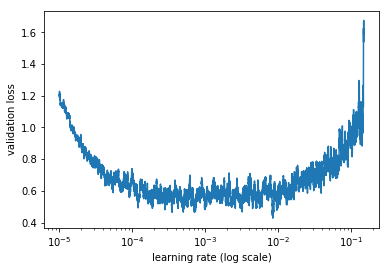

In [22]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [23]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.48598    0.351695   0.866855  


[0.3516948465717536, 0.866854846541199]

In [24]:
learn.save('clas_0_bs10')

In [25]:
learn.load('clas_0_bs10')

In [26]:
learn.freeze_to(-2)

In [27]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.458786   0.33473    0.883925  


[0.33472967805761483, 0.883924738043739]

In [28]:
learn.save('clas_1_bs10')

In [29]:
learn.load('clas_1_bs10')

In [30]:
learn.unfreeze()

In [44]:
learn.fit(lrs, 1, wds=wd, cycle_len=2, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                          
    0      0.292502   0.275451   0.896317  
    1      0.24827    0.268048   0.902097                          


[0.26804793828317236, 0.9020967799929842]

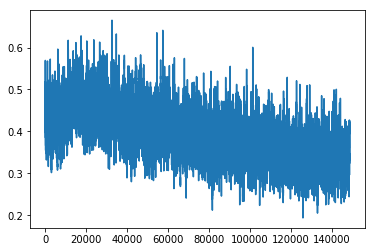

In [33]:
# After 4 epochs
learn.sched.plot_loss()

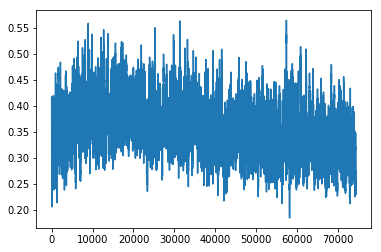

In [45]:
# After 4 + 2 epochs
learn.sched.plot_loss()

In [43]:
learn.save('clas_2_bs10_4plus2epochs')

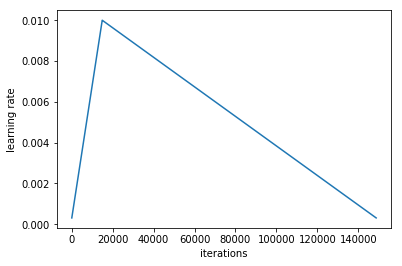

In [35]:
# 4 epochs
learn.sched.plot_lr()

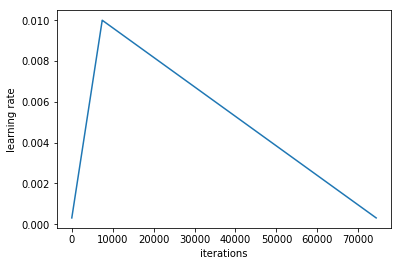

In [46]:
# 4 + 2 epochs
learn.sched.plot_lr()

## Make predictions

In [47]:
%%time

preds, target = learn.predict_with_targs()

CPU times: user 3min 29s, sys: 58.1 s, total: 4min 27s
Wall time: 4min 27s


In [177]:
# Calcualate the inference times
time_taken = 3 * 60 + 17
time_per_sample = time_taken / len(target)
print('Time per sample: {} s'.format(time_per_sample))
print('Samples per second: {}'.format(1/time_per_sample))

Time per sample: 0.014558084540348803 s
Samples per second: 68.69035532994924


In [48]:
pred = preds.argmax(axis=1)

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
conf_mat = confusion_matrix(target, pred, labels = [0, 1, 2])

In [51]:
# funtion to plot confusion matrices, will be needed later

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)

    print(cm)
    
    
    plt.title(title)
    plt.colorbar( )
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.93528 0.05591 0.0088 ]
 [0.03297 0.86943 0.09761]
 [0.00597 0.07475 0.91927]]


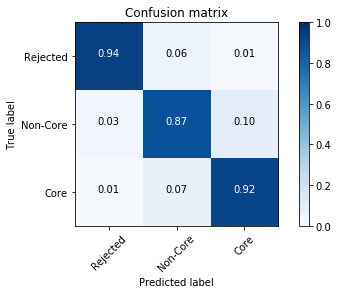

In [52]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=True)
plt.show()

Confusion matrix, without normalization
[[ 7544   451    71]
 [  508 13397  1504]
 [   82  1026 12617]]


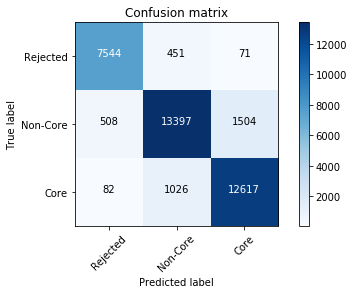

In [53]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=False)
plt.show()

In [476]:
learn.model.combined_network.layers[0]

LinearBlock(
  (lin): Linear(in_features=1250, out_features=50, bias=True)
  (drop): Dropout(p=0.2)
  (bn): BatchNorm1d(1250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

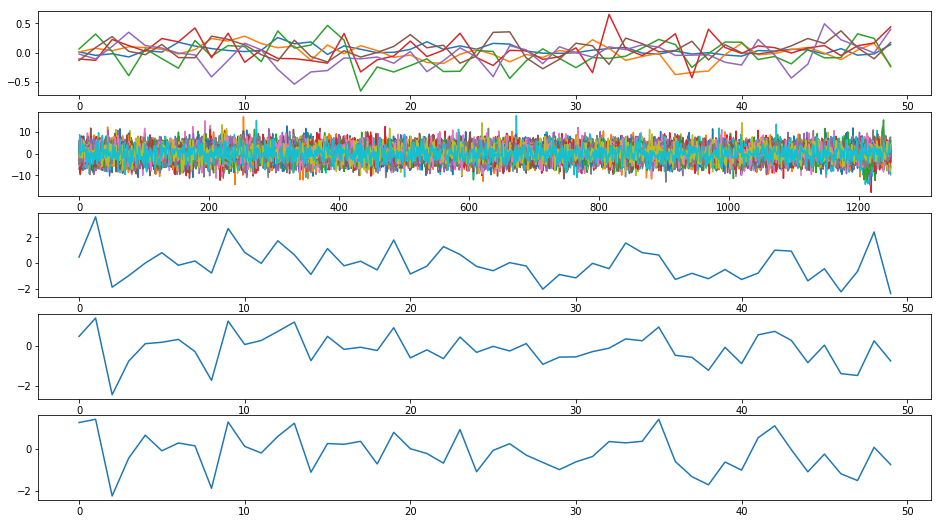

In [94]:
plt.figure(figsize=(16, 9))
plt.subplot(511)
plt.plot(learn.model.reference_network.layers[0].lin.weight.cpu().detach().numpy())
plt.subplot(512)
plt.plot(learn.model.combined_network.layers[0].lin.weight.cpu().detach().numpy().T)
plt.subplot(513)
plt.plot(learn.model.combined_network.layers[1].lin.weight.cpu().detach().numpy().T[:,0])
plt.subplot(514)
plt.plot(learn.model.combined_network.layers[1].lin.weight.cpu().detach().numpy().T[:,1])
plt.subplot(515)
plt.plot(learn.model.combined_network.layers[1].lin.weight.cpu().detach().numpy().T[:,2])

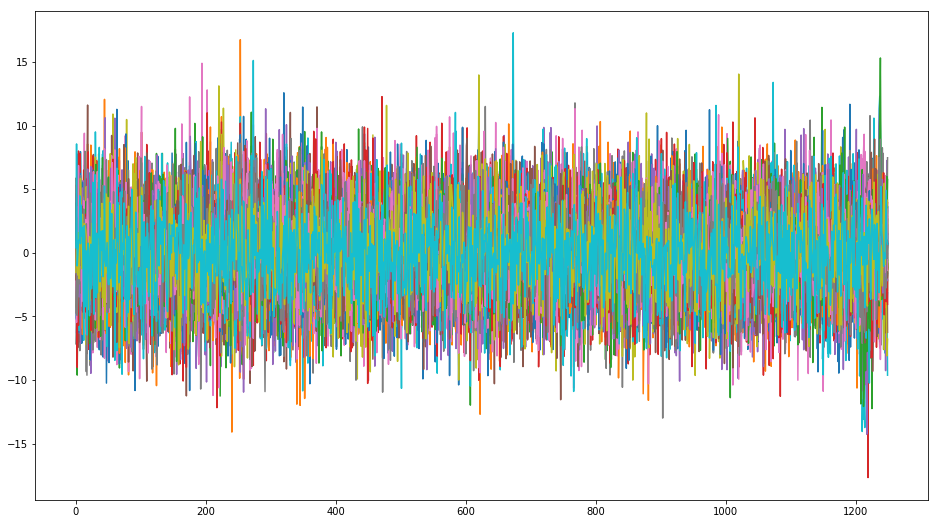

In [95]:
plt.figure(figsize=(16, 9))
plt.plot(learn.model.combined_network.layers[0].lin.weight.cpu().detach().numpy().T)